In [1]:
import xgboost as xgb
import matplotlib as mpl
import matplotlib.pyplot as plt
import uproot3 as uproot
import pandas as pd
import numpy as np
import math
from tqdm import tqdm

import pickle

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from IPython.display import display

# should be xgboost v1.3.0, needs to be old in order to calculate the score correctly!
# uproot can be any version 3 I think
print(xgb.__version__)
print(uproot.__version__)

1.3.0
3.14.4


In [2]:
extra_variables = [
    "run",
    "subrun",
    "event",
    "nuvtx_diff",
    "showervtx_diff",
    "muonvtx_diff",
    "truth_isCC",
    "truth_vtxInside",
    "truth_nuPdg",
    "truth_nuEnergy",
    "truth_nuIntType",
    "truth_energyInside",
    "weight_spline",
    "weight_cv",
    "weight_lee",
    "event_type",
    "weight",
    "lowEweight"
]

numu_bdt_score_variables = [
    "cosmict_10_score",
    "numu_1_score",
    "numu_2_score"
]

nue_bdt_score_variables = [
    "tro_5_score",
    "tro_4_score",
    "tro_2_score",
    "tro_1_score",
    "stw_4_score",
    "stw_3_score",
    "stw_2_score",
    "sig_2_score",
    "sig_1_score",
    "pio_2_score",
    "lol_2_score",
    "lol_1_score",
    "br3_6_score",
    "br3_5_score",
    "br3_3_score"
]

kine_scalar_vars = [
    "kine_reco_add_energy",
    "kine_pio_mass",
    "kine_pio_flag",
    "kine_pio_vtx_dis",
    "kine_pio_energy_1",
    "kine_pio_theta_1",
    "kine_pio_phi_1",
    "kine_pio_dis_1",
    "kine_pio_energy_2",
    "kine_pio_theta_2",
    "kine_pio_phi_2",
    "kine_pio_dis_2",
    "kine_pio_angle"
]

kine_vector_vars = [
    "kine_energy_particle",
    "kine_energy_info",
    "kine_particle_type",
    "kine_energy_included",
]

In [3]:
bdt_vars = [
    "nue_score",
    "numu_score",
    "numu_cc_flag",
    "nc_delta_score"
]

eval_mc_variables = [
    "run",
    "subrun",
    "event",
    "flash_time",
    "weight_spline", # this and remaining only make sense for MC
    "weight_cv",
    "match_completeness_energy",
    "truth_nuEnergy",
    "truth_energyInside",
    "truth_electronInside",
    "truth_nuPdg",
    "truth_isCC",
    "truth_isFC",
    "truth_vtxInside",
    "truth_vtxX",
    "truth_vtxY",
    "truth_vtxZ",
    "truth_nuTime",
]

eval_data_variables = [
    "run",
    "subrun",
    "event",
    "flash_time",
]

pf_eval_mc_variables = [
    "truth_NprimPio",
    "truth_NCDelta",
    "nuvtx_diff",
    "showervtx_diff",
    "reco_showerKE",
    "truth_pio_energy_1",
    "truth_pio_energy_2",
    "reco_nuvtxX",
    "reco_nuvtxY",
    "reco_nuvtxZ",
    "reco_pdg",
    "reco_mother",
    "reco_startMomentum",
]

pf_eval_data_variables = [ # also use these for dirt
    "reco_showerKE",
    "reco_nuvtxX",
    "reco_nuvtxY",
    "reco_nuvtxZ",
    "reco_pdg",
    "reco_mother",
    "reco_startMomentum"
]

pf_eval_data_variables_no_pf_info = [ # also use these for dirt
    "reco_showerKE",
    "reco_nuvtxX",
    "reco_nuvtxY",
    "reco_nuvtxZ",
]

dedicated_pf_eval_mc_variables = [
    "truth_pdg", 
    "truth_mother", 
    "truth_startMomentum",
    "truth_startXYZT",
]


In [4]:
# nc delta file, despite the intrinsic nue name

f_intrinsic_nue_run1 = uproot.open("/data1/hagaman/xin_files/processed_checkout_rootfiles/prodgenie_bnb_nc_delta_overlay_run1_PF/UBGenieFluxSmallUni.root")["wcpselection"]
f_intrinsic_nue_run1_bdt = f_intrinsic_nue_run1["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_intrinsic_nue_run1_eval = f_intrinsic_nue_run1["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_intrinsic_nue_run1_pfeval = f_intrinsic_nue_run1["T_PFeval"].pandas.df(pf_eval_mc_variables + dedicated_pf_eval_mc_variables, flatten=False)
f_intrinsic_nue_run1_kine = f_intrinsic_nue_run1["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_intrinsic_nue_run1_pot = f_intrinsic_nue_run1["T_pot"].pandas.df("pot_tor875good", flatten=False)
intrinsic_nue_run1_POT = np.sum(f_intrinsic_nue_run1_pot["pot_tor875good"].to_numpy())
intrinsic_nue_run1_df = pd.concat([f_intrinsic_nue_run1_bdt, f_intrinsic_nue_run1_eval, f_intrinsic_nue_run1_pfeval, f_intrinsic_nue_run1_kine], axis=1, sort=False)
del f_intrinsic_nue_run1
del f_intrinsic_nue_run1_bdt
del f_intrinsic_nue_run1_eval
del f_intrinsic_nue_run1_pfeval
del f_intrinsic_nue_run1_kine
del f_intrinsic_nue_run1_pot
intrinsic_nue_run1_df["isEXT"] = [0 for i in range(intrinsic_nue_run1_df.shape[0])]
intrinsic_nue_run1_df["isDirt"] = [0 for i in range(intrinsic_nue_run1_df.shape[0])]
intrinsic_nue_run1_df["WC_file"] = ["intrinsic_nue_run1" for i in range(intrinsic_nue_run1_df.shape[0])]
intrinsic_nue_run1_df["run_num"] = [1 for i in range(intrinsic_nue_run1_df.shape[0])]


all_df = intrinsic_nue_run1_df

In [5]:
# adding truth primary particle nums, only for numu and nue

num_prim_photons = []
num_prim_protons = []
num_prim_nonprim_protons = []
num_prim_charged_pions = []
num_prim_neutrons = []
num_prim_electrons = []
num_prim_muons = []
num_prim_pi0s = []
num_prim_others = []

max_proton_true_kinetic_energies = []
max_pion_true_kinetic_energies = []

photon_thetas = []
photon_phis = []
photon_energies = []

runnum = all_df["run_num"].to_numpy()
run = all_df["run"].to_numpy()
subrun = all_df["subrun"].to_numpy()
event = all_df["event"].to_numpy()

truth_pdgs = all_df["truth_pdg"].to_numpy()
truth_mothers = all_df["truth_mother"].to_numpy()
truth_startMomentums = all_df["truth_startMomentum"].to_numpy()

for i in tqdm(range(all_df.shape[0])):
    #for i in tqdm(range(10)):
    #print("new event")

    num_prim_nonprim_proton = 0
    
    truth_pdg_list = truth_pdgs[i]
    truth_mother_list = truth_mothers[i]
    truth_startMomentum_list = truth_startMomentums[i]

    for j in range(len(truth_pdg_list)):
        if truth_pdg_list[j] == 2212:
            #print(truth_startMomentum_list[j][3] * 1000. - 938.272)
            if truth_startMomentum_list[j][3] * 1000. - 938.272 > 35.:
                num_prim_nonprim_proton += 1

    num_prim_nonprim_protons.append(num_prim_nonprim_proton)

all_df["num_prim_nonprim_protons"] = num_prim_nonprim_protons


100%|██████████████████████████████████| 40522/40522 [00:02<00:00, 15597.92it/s]


In [6]:
normalizing_POT_run1 = 1.423e20
normalizing_POT_run2 = 2.541e20
normalizing_POT_run3 = 2.405e20

weight_cv = all_df["weight_cv"].to_numpy()
weight_spline = all_df["weight_spline"].to_numpy()
is_ext = all_df["isEXT"].to_numpy()
is_dirt = all_df["isDirt"].to_numpy()
is_nc_delta = all_df["truth_NCDelta"].to_numpy() # should give 0 for data (truth_NCDelta==NaN)
is_CC = all_df["truth_isCC"].to_numpy() # should give 0 for data (truth_isCC==NaN)
num_pi0 = all_df["truth_NprimPio"].to_numpy() # should give 0 for data (truth_NprimPio==NaN)
truth_nuPdgs = all_df["truth_nuPdg"].to_numpy()


run_nums = all_df["run_num"].to_numpy()
WC_file_str = all_df["WC_file"].to_numpy()
net_weights = []
for i in tqdm(range(len(weight_cv))):
    weight_temp = weight_cv[i] * weight_spline[i]
    if weight_temp <= 0. or weight_temp > 30. or np.isnan(weight_temp): # something went wrong with the saved weights
        weight_temp = 1.
        
    net_weights.append(normalizing_POT_run1 / intrinsic_nue_run1_POT)
            
all_df["net_weight"] = net_weights


100%|█████████████████████████████████| 40522/40522 [00:00<00:00, 278748.02it/s]


In [7]:
# adding proton and pion nums, adjusting em scale for reco_showerKE and kine_reco_Enu

proton_nums = []
track_nums = []
energy_lists = all_df["kine_energy_particle"].to_numpy()
pdg_lists = all_df["kine_particle_type"].to_numpy()
for i in tqdm(range(all_df.shape[0])):
    proton_num = 0
    track_num = 0
    energy_list = energy_lists[i]
    pdg_list = pdg_lists[i]
    for j in range(len(energy_list)):
        if abs(pdg_list[j]) == 2212 and energy_list[j] > 35.:
            proton_num += 1
        if abs(pdg_list[j]) == 13 or abs(pdg_list[j]) == 211 and energy_list[j] > 10.: # see N_tracks at https://github.com/BNLIF/wcp-uboone-bdt/blob/main/inc/WCPLEEANA/cuts.h
            track_num += 1
    proton_nums.append(proton_num)
    track_nums.append(track_num)
all_df["num_protons"] = proton_nums
all_df["num_other_tracks"] = track_nums


100%|██████████████████████████████████| 40522/40522 [00:00<00:00, 55596.13it/s]


In [8]:
sel_df = all_df.query("kine_reco_Enu > 0 and match_isFC==1 and nc_delta_score > 2.61 and num_protons > 0")
sel_Np_df = sel_df.query("num_prim_nonprim_protons > 0")
sel_0p_df = sel_df.query("num_prim_nonprim_protons == 0")


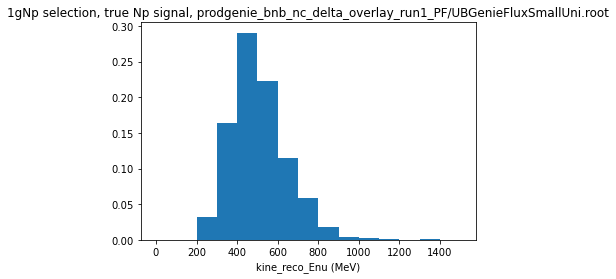

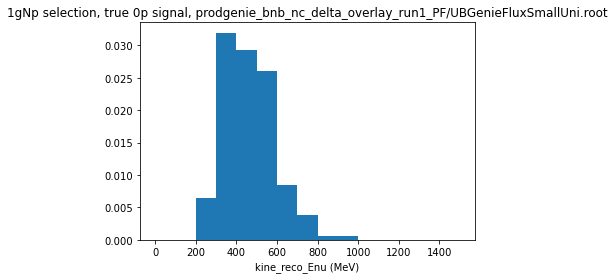

In [9]:
plt.figure()
plt.hist(sel_Np_df["kine_reco_Enu"].to_numpy(), weights=sel_Np_df["net_weight"].to_numpy(), range=(0, 1500), bins=15)
plt.title("1gNp selection, true Np signal, prodgenie_bnb_nc_delta_overlay_run1_PF/UBGenieFluxSmallUni.root")
plt.xlabel("kine_reco_Enu (MeV)")
plt.show()

plt.figure()
plt.hist(sel_0p_df["kine_reco_Enu"].to_numpy(), weights=sel_0p_df["net_weight"].to_numpy(), range=(0, 1500), bins=15)
plt.title("1gNp selection, true 0p signal, prodgenie_bnb_nc_delta_overlay_run1_PF/UBGenieFluxSmallUni.root")
plt.xlabel("kine_reco_Enu (MeV)")
plt.show()


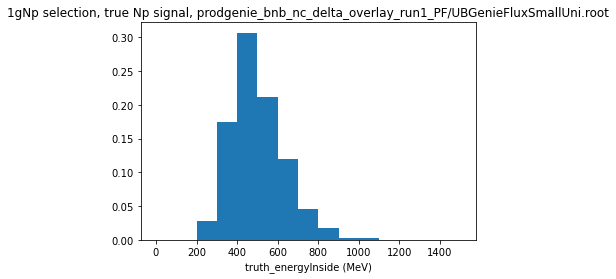

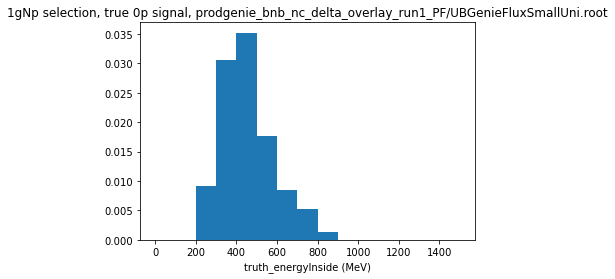

In [11]:
plt.figure()
plt.hist(sel_Np_df["truth_energyInside"].to_numpy(), weights=sel_Np_df["net_weight"].to_numpy(), range=(0, 1500), bins=15)
plt.title("1gNp selection, true Np signal, prodgenie_bnb_nc_delta_overlay_run1_PF/UBGenieFluxSmallUni.root")
plt.xlabel("truth_energyInside (MeV)")
plt.show()

plt.figure()
plt.hist(sel_0p_df["truth_energyInside"].to_numpy(), weights=sel_0p_df["net_weight"].to_numpy(), range=(0, 1500), bins=15)
plt.title("1gNp selection, true 0p signal, prodgenie_bnb_nc_delta_overlay_run1_PF/UBGenieFluxSmallUni.root")
plt.xlabel("truth_energyInside (MeV)")
plt.show()

